In [1]:
# ! pip install 
# ! pip install xformers
# ! pip install Pillow

In [3]:

%load_ext autoreload
%autoreload 2

from local_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2024-10-29 02:17:33.277215: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
import torch
import numpy as np
from diffusers import ControlNetModel, StableDiffusionControlNetInpaintPipeline
# from diffusers.utils import load_image, make_image_grid
from diffusers.utils import load_image

# load ControlNet
controlnet = ControlNetModel.from_pretrained("lllyasviel/control_v11p_sd15_inpaint", torch_dtype=torch.float16, variant="fp16")

# pass ControlNet to the pipeline
pipeline = StableDiffusionControlNetInpaintPipeline.from_pretrained(
    "runwayml/stable-diffusion-inpainting", controlnet=controlnet, torch_dtype=torch.float16, variant="fp16"
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
pipeline.enable_xformers_memory_efficient_attention()


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


## 이미지 준비

In [5]:
# load base and mask image
init_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png")
mask_image = load_image("https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png")
init_image, mask_image


(<PIL.Image.Image image mode=RGB size=512x512>,
 <PIL.Image.Image image mode=RGB size=512x512>)

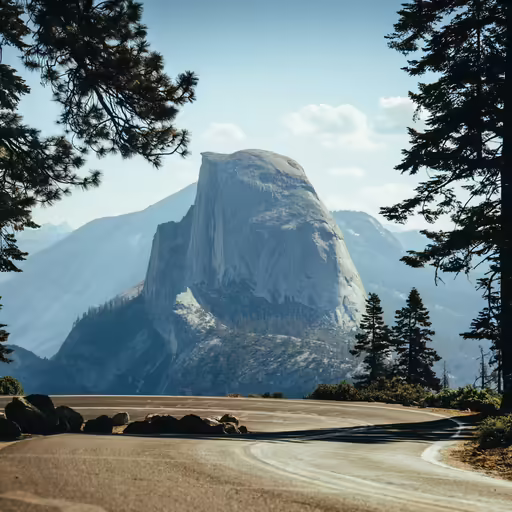

In [6]:
init_image

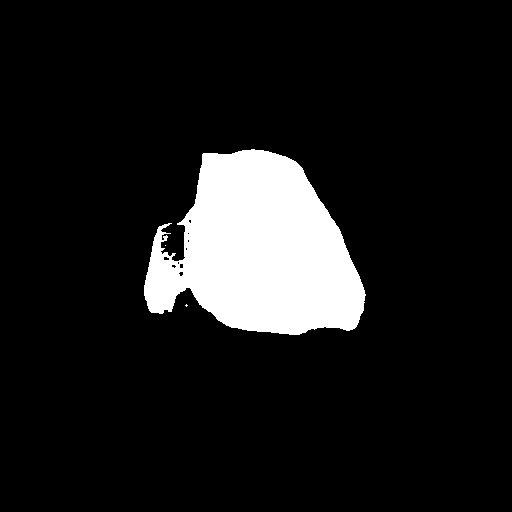

In [7]:
mask_image

### Control 이미지 생성

In [8]:

from local_utils import make_inpaint_condition
control_image = make_inpaint_condition(init_image, mask_image)
control_image.shape

torch.Size([1, 3, 512, 512])

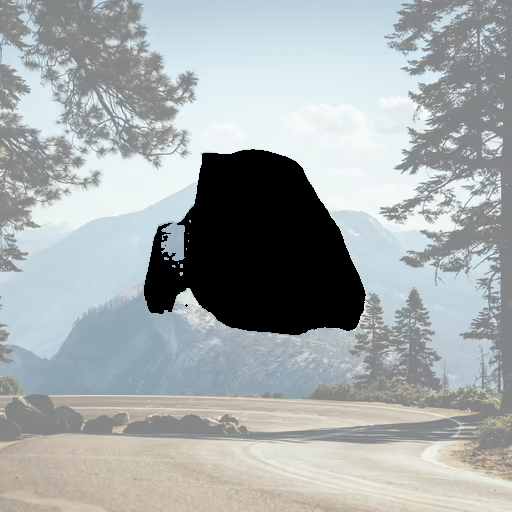

In [9]:

# 사용 예시
img_alt = tensor_to_image_alternative(control_image)
display(img_alt)

## 이미지 생성

  0%|          | 0/50 [00:00<?, ?it/s]

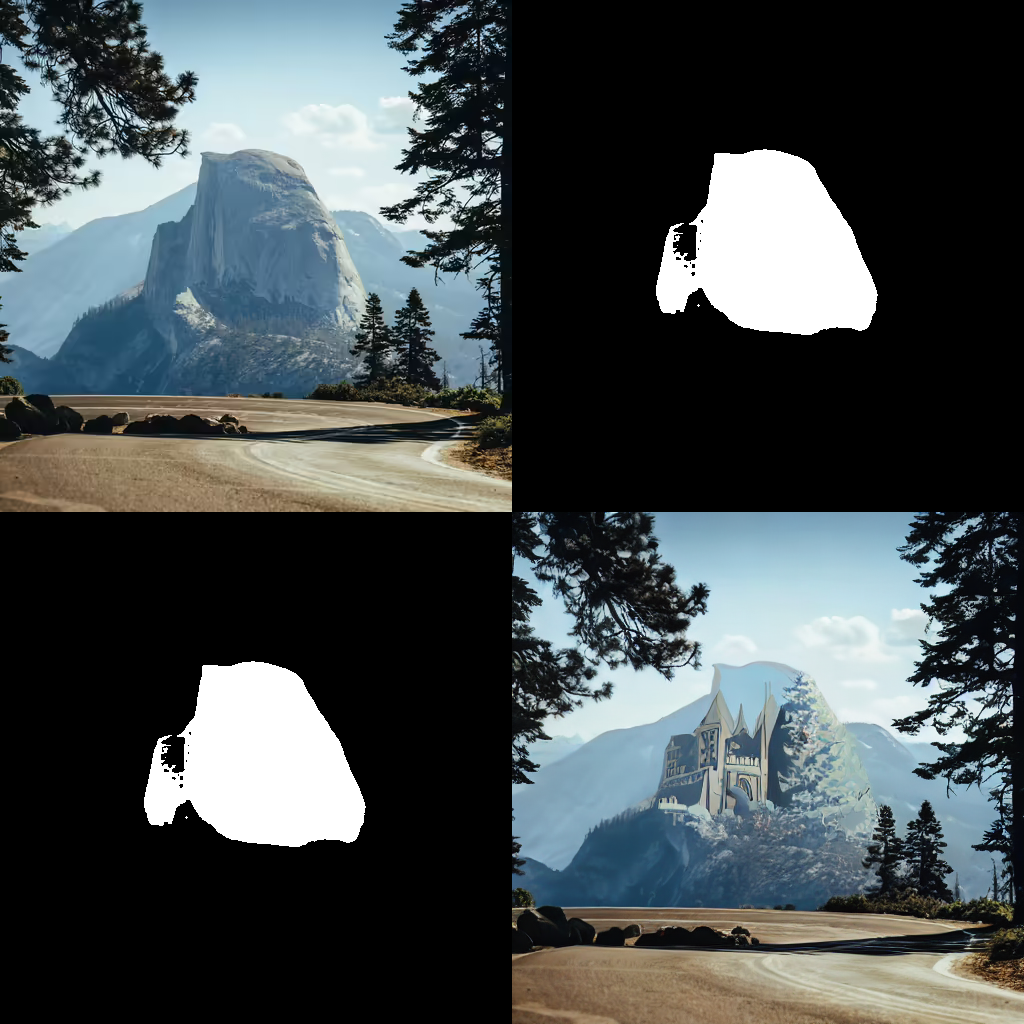

In [10]:
# 기존 코드 실행
prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"
image = pipeline(prompt=prompt, image=init_image, mask_image=mask_image, control_image=control_image).images[0]

# 이미지 그리드 생성
grid = make_image_grid([
    init_image, 
    mask_image, 
    Image.fromarray(np.uint8(control_image[0][0])).convert('RGB'), 
    image
], rows=2, cols=2)

# 결과 표시
display(grid)

## 사람 얼굴 인페인팅

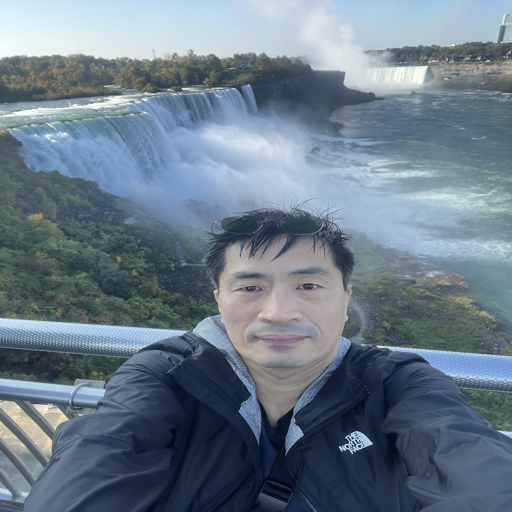

In [11]:
input_face_img = "input_image/gonsoo_fall.jpg"
face_image = Image.open(input_face_img).resize((512, 512))  # 얼굴 이미지
face_image

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

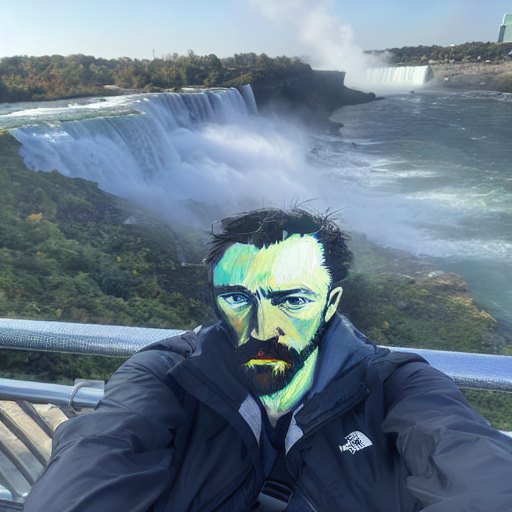

In [12]:

# 사용 예시

mask_image = Image.open("face_mask.png").resize((512, 512))        # 얼굴 마스크

# 다양한 스타일 예시
styles = {
    "고흐": "portrait in the style of Van Gogh's painting, vibrant colors, expressive brushstrokes, starry night style",
    "피카소": "portrait in the style of Picasso's cubism painting, geometric shapes, abstract, modern art",
    "모네": "portrait in the style of Monet's impressionism, soft colors, light effects, brushstrokes",
    "일본 애니메이션": "portrait in the style of anime illustration, detailed, Studio Ghibli style",
    "수채화": "portrait in watercolor painting style, soft edges, flowing colors, artistic"
}

from local_utils import create_styled_portrait

# 원하는 스타일로 변환
styled_image = create_styled_portrait(
    face_image=face_image,
    mask_image=mask_image,
    style_prompt=styles["고흐"]  # 원하는 스타일 선택
)

# 결과 표시
styled_image.show()

## 얼굴 스와핑 인페인팅 (시도1)

In [13]:
from local_utils import create_simple_face_mask, transform_face

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

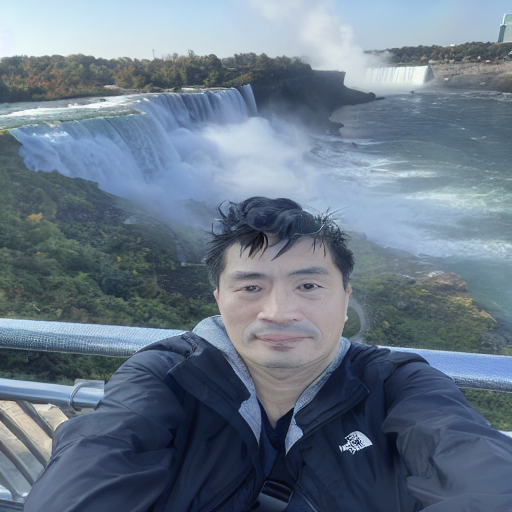

In [16]:

# 사용 예시
target_image_path = face_image  # 폭포 배경의 셀카
style_prompt = """a man in renaissance painter style, elegant costume, detailed face features like in the reference image, 
                 black velvet coat with golden embroidery, white lace collar, renaissance style, 
                 oil painting, masterpiece, highly detailed"""

# 얼굴 변환 실행



result = transform_face(
    target_image_path=target_image_path,
    style_prompt=style_prompt,
    mask_size_ratio=0.2,  # 마스크 크기 조절
    center_y_ratio=0.35   # 마스크 위치 조절
)

# 결과 표시 및 저장
display(result)
result.save("transformed_face.png")

## 얼굴 스와핑 인페인팅 (시도2)

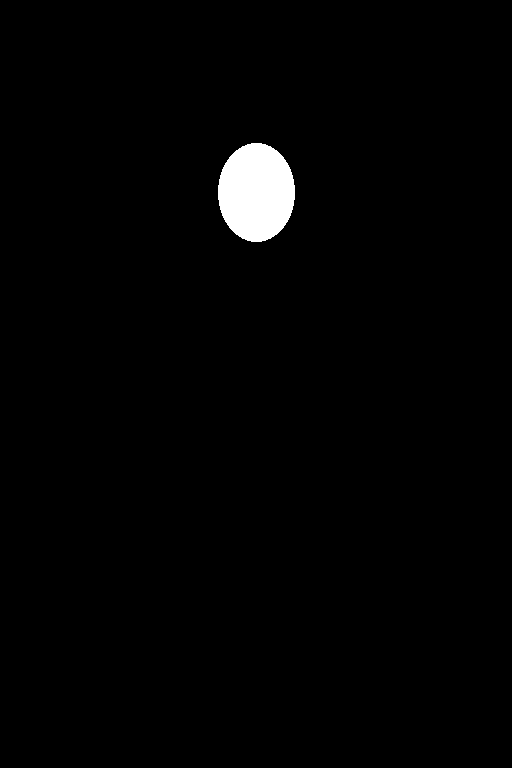

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/50 [00:00<?, ?it/s]

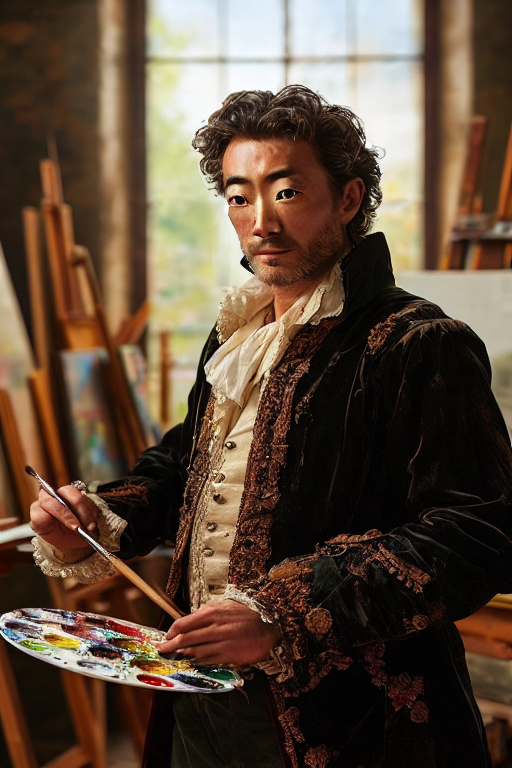

In [19]:
from local_utils import create_face_mask, replace_face

# 이미지 경로 설정
painter_image_path = "input_image/painter.jpeg"    # 화가 이미지 경로
my_face_image_path = "input_image/gonsoo_fall.jpg"    # 내 얼굴 이미지 경로

# 마스크 테스트 (선택사항)
test_image, test_mask = create_face_mask(painter_image_path)
display(test_mask)  # 마스크 위치 확인

# 얼굴 교체 실행
result = replace_face(
    painter_image_path=painter_image_path,
    my_face_image_path=my_face_image_path,
    mask_size_ratio=0.15,  # 마스크 크기 조절 (필요시 조정)
    center_y_ratio=0.25    # 마스크 위치 조절 (필요시 조정)
)

# 결과 표시 및 저장
display(result)
result.save("face_replaced_painter.png")

2024-10-29 07:15:57.774574: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


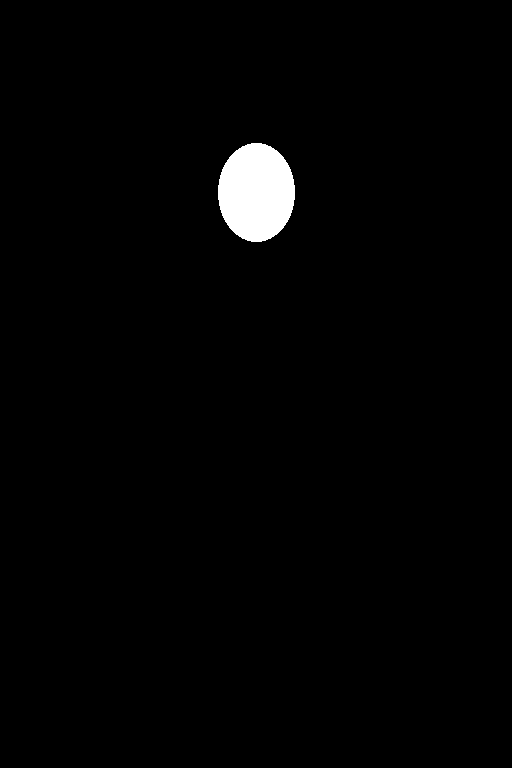

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/15 [00:00<?, ?it/s]

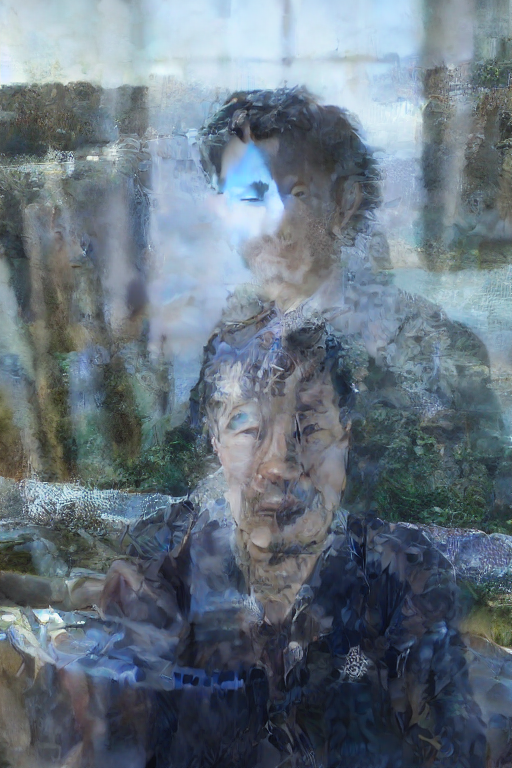

In [1]:
from local_utils import create_face_mask, replace_face, blend_faces

# 이미지 경로 설정
painter_image_path = "input_image/painter.jpeg"    # 화가 이미지 경로
my_face_image_path = "input_image/gonsoo_fall.jpg"    # 내 얼굴 이미지 경로

# 마스크 테스트 (선택사항)
test_image, test_mask = create_face_mask(painter_image_path)
display(test_mask)  # 마스크 위치 확인

# 얼굴 합성 실행
result = blend_faces(
    painter_image_path=painter_image_path,
    my_face_image_path=my_face_image_path,
    mask_size_ratio=0.15,
    center_y_ratio=0.25,
    strength=0.3  # 낮은 변환 강도로 원본 특징 유지
)

# 결과 표시 및 저장
display(result)
result.save("face_blended_painter.png")

### 사람 얼굴 이미지 교체 ( 시도 3)

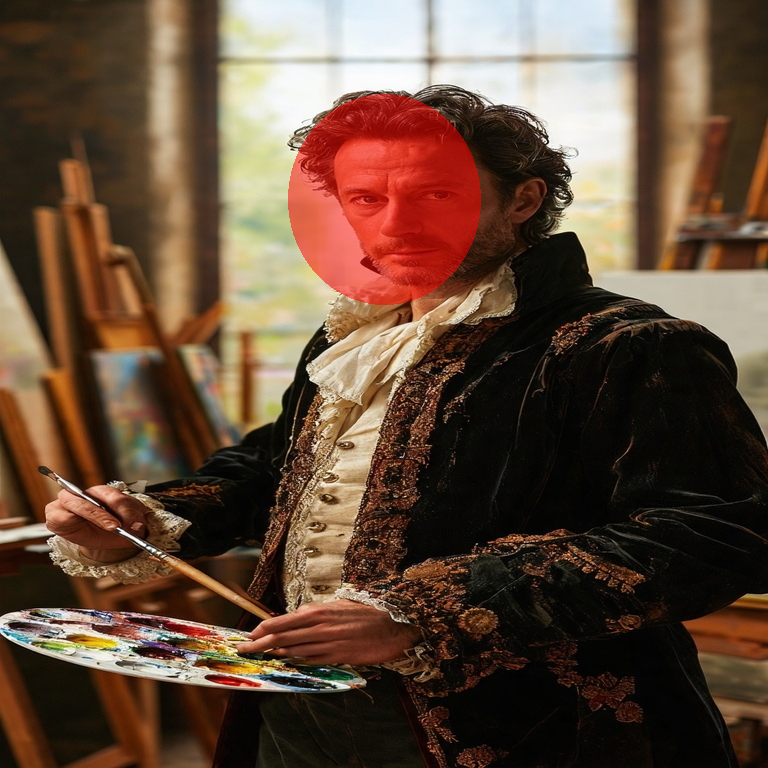

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

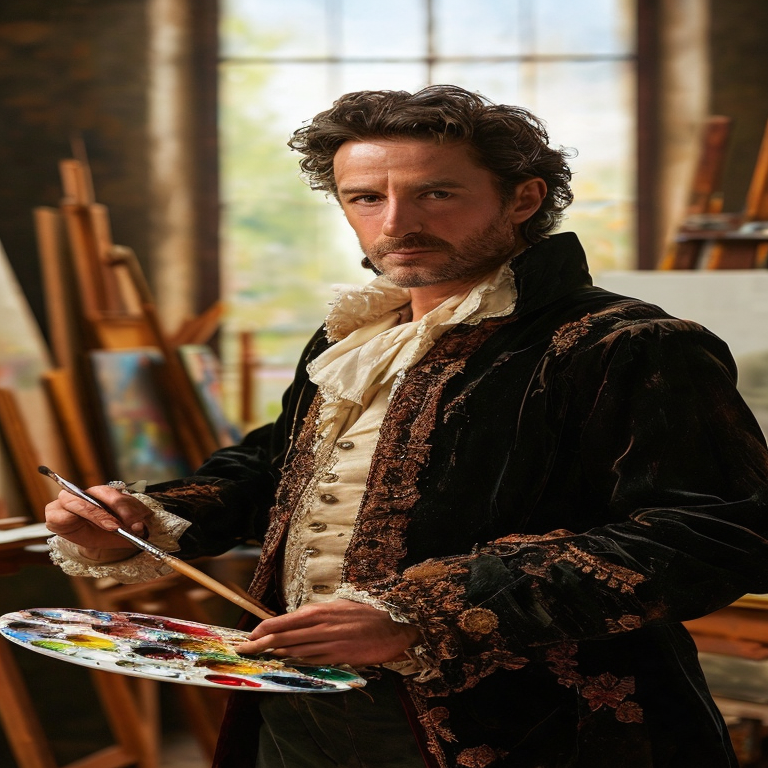

In [14]:
from PIL import Image, ImageDraw
import numpy as np
import torch
from diffusers import StableDiffusionInpaintPipeline
import os

# 필요한 폴더 생성
os.makedirs("input_image", exist_ok=True)
os.makedirs("output_image", exist_ok=True)

def create_face_mask(image_path, center_y_ratio=0.26, mask_size_ratio=0.25):  # 마스크 크기 축소
    """
    화가 이미지의 얼굴 부분에 대한 마스크 생성
    """
    image = Image.open(image_path) if isinstance(image_path, str) else image_path
    image = image.resize((768, 768), Image.Resampling.LANCZOS)
    
    mask = Image.new('L', (768, 768), 0)
    draw = ImageDraw.Draw(mask)
    
    # 얼굴 위치 조정
    center_x = 384
    center_y = int(768 * center_y_ratio)
    
    # 얼굴 영역만을 위한 타원
    face_radius_x = int(384 * mask_size_ratio)
    face_radius_y = int(384 * mask_size_ratio * 1.1)  # 세로 비율 약간만 늘림
    
    # 얼굴 타원
    draw.ellipse([
        center_x - face_radius_x, center_y - face_radius_y,
        center_x + face_radius_x, center_y + face_radius_y
    ], fill=255)
    
    # 작은 크기의 턱 영역 추가
    chin_center_y = center_y + face_radius_y * 0.2
    chin_radius_x = face_radius_x * 0.8
    chin_radius_y = face_radius_y * 0.3
    
    draw.ellipse([
        center_x - chin_radius_x, chin_center_y - chin_radius_y,
        center_x + chin_radius_x, chin_center_y + chin_radius_y
    ], fill=255)
    
    return image, mask

def preview_mask(image, mask):
    """마스크 미리보기 생성"""
    preview = image.copy()
    overlay = Image.new('RGBA', image.size, (255, 0, 0, 0))
    overlay.paste((255, 0, 0, 128), mask=mask)
    preview = Image.alpha_composite(preview.convert('RGBA'), overlay)
    return preview

def replace_face_inpaint(
    painter_image_path,
    my_face_image_path,
    mask_size_ratio=0.25,    # 마스크 크기 축소
    center_y_ratio=0.26      # 위치 조정
):
    # SD 2.1 모델 사용
    pipe = StableDiffusionInpaintPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-1",
        torch_dtype=torch.float16,
        safety_checker=None
    ).to("cuda")
    
    image, mask = create_face_mask(
        painter_image_path,
        center_y_ratio=center_y_ratio,
        mask_size_ratio=mask_size_ratio
    )
    
    # 프롬프트 수정 - 얼굴에 더 집중
    face_prompt = """exact copy of the reference Asian male face,
                    highly detailed facial features, natural skin texture,
                    perfect face proportions, detailed eyes and eyebrows,
                    natural nose and mouth, renaissance style painting,
                    seamless integration, professional portrait"""

    negative_prompt = """deformed, distorted, disfigured, unnatural,
                        bad anatomy, different face structure,
                        modified facial features, bad proportions"""
    
    output = pipe(
        prompt=face_prompt,
        image=image,
        mask_image=mask,
        guidance_scale=3.0,      # 낮은 값으로 유지
        num_inference_steps=150,
        negative_prompt=negative_prompt,
        strength=0.2             # 낮은 값으로 유지
    ).images[0]
    
    return output, mask

def main():
    # 이미지 경로 설정
    painter_image_path = "input_image/painter.jpeg"
    my_face_image_path = "input_image/gonsoo_fall.jpg"

    # 마스크 미리보기
    test_image, test_mask = create_face_mask(painter_image_path)
    mask_preview = preview_mask(test_image, test_mask)
    display(mask_preview)  # 마스크 위치 확인

    # 얼굴 교체 실행
    result, mask = replace_face_inpaint(
        painter_image_path=painter_image_path,
        my_face_image_path=my_face_image_path
    )

    # 결과 저장
    display(result)
    result.save("output_image/face_inpainted_result_sd21.png")

if __name__ == "__main__":
    main()